# Работа с полным датасетом Omniglot

---



# Загрузка полного датасета Omniglot

Загрузка датасета

In [12]:
from sklearn.metrics import accuracy_score
from google.colab import drive

import numpy as np
import zipfile
import io
import os

NUMBER_OF_CLASSES = 1600
PATH = 'drive/My Drive/Few-Shot-Learning/Omniglot-data-set'

drive.mount('/content/drive')

with zipfile.ZipFile(os.path.join(PATH, 'train_images.zip')) as zipper:
    with io.BufferedReader(zipper.open('train_images.txt', mode='r')) as file:
        X_train = np.resize(np.loadtxt(file, dtype=np.uint8), (14 * NUMBER_OF_CLASSES, 1, 105, 105))
        
with zipfile.ZipFile(os.path.join(PATH, 'train_labels.zip')) as zipper:
    with io.BufferedReader(zipper.open('train_labels.txt', mode='r')) as file:
        y_train = np.resize(np.loadtxt(file, dtype='str'), (14 * NUMBER_OF_CLASSES))
        
with zipfile.ZipFile(os.path.join(PATH, 'test_images.zip')) as zipper:
    with io.BufferedReader(zipper.open('test_images.txt', mode='r')) as file:
        X_test = np.resize(np.loadtxt(file, dtype=np.uint8), (6 * NUMBER_OF_CLASSES, 1, 105, 105))
        
with zipfile.ZipFile(os.path.join(PATH, 'test_labels.zip')) as zipper:
    with io.BufferedReader(zipper.open('test_labels.txt', mode='r')) as file:
        y_test = np.resize(np.loadtxt(file, dtype='str'), (6 * NUMBER_OF_CLASSES))

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


Определение трансформации

In [13]:
!pip install -q -U albumentations
import albumentations as A

from albumentations.pytorch import ToTensorV2

transform = A.Compose([A.SmallestMaxSize(max_size=105),
                       A.CenterCrop(height=84, width=84),
                       A.Normalize(mean=(0.5), std=(0.5)),
                       ToTensorV2(),])

Определение тензоров

In [14]:
import torch

train_images = torch.stack([transform(image=x[0])["image"] for x in X_train]).float()
test_images = torch.stack([transform(image=x[0])["image"] for x in X_test]).float()

classes = [y_train[14 * i] for i in range(NUMBER_OF_CLASSES)]

train_labels = torch.from_numpy(np.array([[i] for i in range(NUMBER_OF_CLASSES) for _ in range(14)])).long()
test_labels = torch.from_numpy(np.array([[i] for i in range(NUMBER_OF_CLASSES) for _ in range(6)])).long()

Определение вспомогательной функции для подготовки выборки

In [22]:
import random

def shuffle_tensor(tensor, batch_size, count=14):
    random.shuffle(tensor)

    images, labels = zip(*tensor)

    images = torch.stack(images[:])
    labels = torch.stack(labels[:])

    images = images.view(count * NUMBER_OF_CLASSES // batch_size, batch_size, 1, 84, 84).float()
    labels = labels.view(count * NUMBER_OF_CLASSES // batch_size, batch_size).long()

    return list(zip(images, labels))

# Визуализация датасета Omniglot (полный датасет)

label: ULOG_03


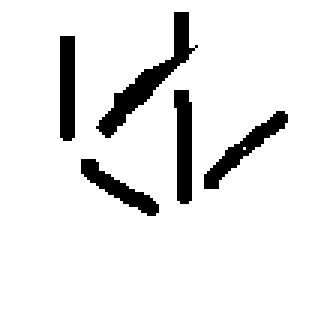

In [17]:
from PIL import Image

digit_number = -1

image = Image.fromarray(X_train[digit_number].reshape(105, 105), mode='P')

print('label: {}'.format(y_train[digit_number]))
display(image.resize((315, 315)))

# Использование полносвязной нейронной сети для решения задачи классификации рукописных символов (полный датасет)

Создание полносвязной нейронной сети

In [88]:
import torch.nn as nn
import torch.nn.functional as F


class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.drop = nn.Dropout(p=0.2)
        self.fc1 = nn.Linear(84 * 84, 3600)
        self.fc2 = nn.Linear(3600, 2000)
        self.fc3 = nn.Linear(2000, 1600)

    def forward(self, x):
        x = x.view(-1, 84 * 84)
        x = F.relu(self.drop(self.fc1(x)))
        x = F.relu(self.drop(self.fc2(x)))
        x = self.fc3(x)
        return x

Обучение полносвязной нейронной сети

In [ ]:
import torch.optim as optim

net = Net().cuda()

criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(net.parameters(), lr=0.001, momentum=0.9)

for iteration in range(800):
    trainset = shuffle_tensor(list(zip(train_images, train_labels)), 400)

    for data in trainset:
        images, labels = data[0].cuda(), data[1].cuda()

        optimizer.zero_grad()

        labels_pred = net(images.unsqueeze(0))
        loss = criterion(labels_pred, labels)

        loss.backward()
        optimizer.step()

Использование полносвязной нейронной сети

In [99]:
labels_pred = []
labels_true = []

net.eval()

testset = shuffle_tensor(list(zip(test_images, test_labels)), 400, 6)

for data in testset:
    images, labels = data[0].cuda(), data[1].cuda()

    labels_pred.append(net(images.unsqueeze(0)).cpu().detach().numpy())
    labels_true.append(labels.cpu().detach().numpy())

labels_pred = np.reshape(np.array(labels_pred), (6 * NUMBER_OF_CLASSES, -1))
labels_true = np.reshape(np.array(labels_true), (-1))

predicted = np.argmax(labels_pred, axis=1)

Вычисление метрик

In [100]:
print('accuracy {:.3}'.format(accuracy_score(labels_true, predicted)))

accuracy 0.36


# Использование сверточной нейронной сети для решения задачи классификации рукописных символов (полный датасет)

Создание сверточной нейронной сети

In [60]:
import torch.nn as nn
import torch.nn.functional as F


class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.conv1 = nn.Conv2d(1, 16, 3)
        self.conv2 = nn.Conv2d(16, 32, 3)
        self.pool = nn.MaxPool2d(2, 2)
        self.bnorm1 = nn.BatchNorm2d(16)
        self.bnorm2 = nn.BatchNorm2d(32)
        self.drop = nn.Dropout(p=0.2)
        self.fc1 = nn.Linear(32 * 19 * 19, 3600)
        self.fc2 = nn.Linear(3600, 1600)

    def forward(self, x):
        x = F.relu(self.bnorm1(self.pool(self.conv1(x))))
        x = F.relu(self.bnorm2(self.pool(self.conv2(x))))
        x = x.view(-1, 32 * 19 * 19)
        x = F.relu(self.drop(self.fc1(x)))
        x = self.fc2(x)
        return x

Обучение сверточной нейронной сети

In [ ]:
import torch.optim as optim

net = Net().cuda()

criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(net.parameters(), lr=0.001, momentum=0.9)

for iteration in range(400):
    trainset = shuffle_tensor(list(zip(train_images, train_labels)), 400)

    for data in trainset:
        images, labels = data[0].cuda(), data[1].cuda()

        optimizer.zero_grad()

        labels_pred = net(images)
        loss = criterion(labels_pred, labels)

        loss.backward()
        optimizer.step()

Использование сверточной нейронной сети

In [86]:
labels_pred_s = []
labels_true_s = []

net.eval()

testset = shuffle_tensor(list(zip(test_images, test_labels)), 400, 6)

for data in testset:
    images, labels = data[0].cuda(), data[1].cuda()

    labels_pred_s.append(net(images).cpu().detach().numpy())
    labels_true_s.append(labels.cpu().detach().numpy())

labels_pred_s = np.reshape(np.array(labels_pred_s), (6 * NUMBER_OF_CLASSES, -1))
labels_true_s = np.reshape(np.array(labels_true_s), (-1))

predicted_s = np.argmax(labels_pred_s, axis=1)

Вычисление метрик

In [87]:
print('accuracy {:.3}'.format(accuracy_score(labels_true_s, predicted_s)))

accuracy 0.45


# Сравнение результатов работы нейронных сетей для уменьшенного и полного датасета Omniglot

In [101]:
from sklearn.metrics import accuracy_score

print('Neural network accuracy              : {:.3}'.format(accuracy_score(labels_true, predicted)))
print('Convolutional Neural network accuracy: {:.3}'.format(accuracy_score(labels_true_s, predicted_s)))

Neural network accuracy              : 0.36
Convolutional Neural network accuracy: 0.45


Как показывают результаты выше, увеличение числа классов в задаче классификации в 16 раз отнюдь не прошло бесследно. Но стоит отметить, что даже при таком глобальном масштабировании условия задачи, итоговые результаты хоть и просели, но показывают завидные показатели для такой задачи. В целом сложно что-то сказать об успешности эксперимента и данные две модели будут использованы в качестве байзлайна для дальнейших исследований.